# Benchmarking Results

In [9]:
import helper_functions.plot_functions as plot_funcs

### 1. Baseline execute time

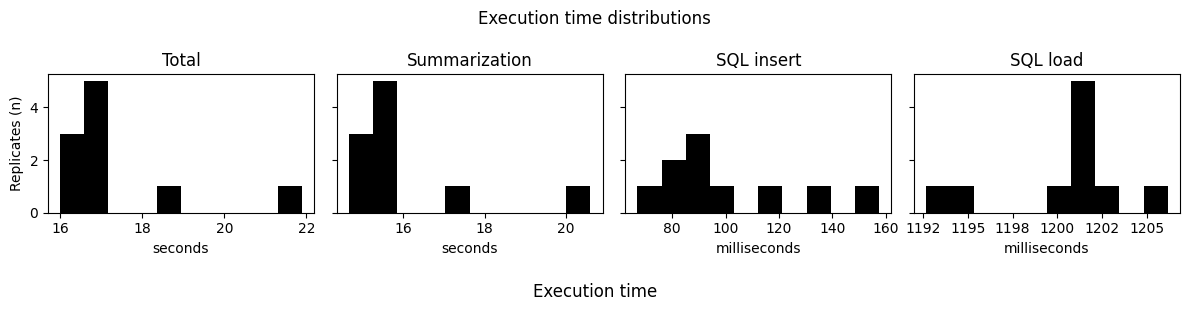

,replicate,num_abstracts,total_replicate_time,total_summarization_time,total_insert_time,total_loading_time,mean_total_time,mean_summarization_time,mean_insert_time,mean_loading_time
0,1,3,65.672780,61.801335,0.268359,3.603086,21.890927,20.600445,0.089453,1.201029
1,2,3,51.169636,47.098700,0.472522,3.598414,17.056545,15.699567,0.157507,1.199471
2,3,3,51.191517,47.301782,0.284421,3.605313,17.063839,15.767261,0.094807,1.201771
3,4,3,48.681545,44.815677,0.247361,3.618507,16.227182,14.938559,0.082454,1.206169
4,5,3,50.179890,46.316243,0.259831,3.603815,16.726630,15.438748,0.086610,1.201272


In [10]:
data, plt = plot_funcs.baseline_execution_plot('../benchmarks/baseline_execute_time/results.csv')

plt.show()
data.head()


### 2. Huggingface device map

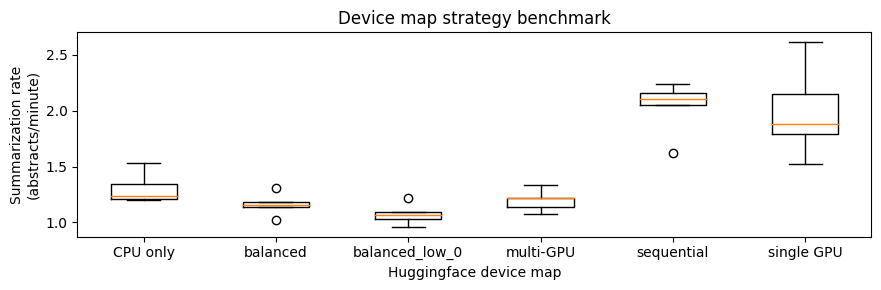

,replicate,abstracts,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,1,3,CPU only,48.627154,0.020565,1.233879
1,2,3,CPU only,44.645400,0.022399,1.343923
2,3,3,CPU only,49.478651,0.020211,1.212644
3,4,3,CPU only,49.861394,0.020056,1.203336
4,5,3,CPU only,39.092824,0.025580,1.534809


In [11]:
data, plt = plot_funcs.device_map_plot('../benchmarks/huggingface_device_map/results.csv')

plt.show()
data.head()

### 3. Parallel summarization

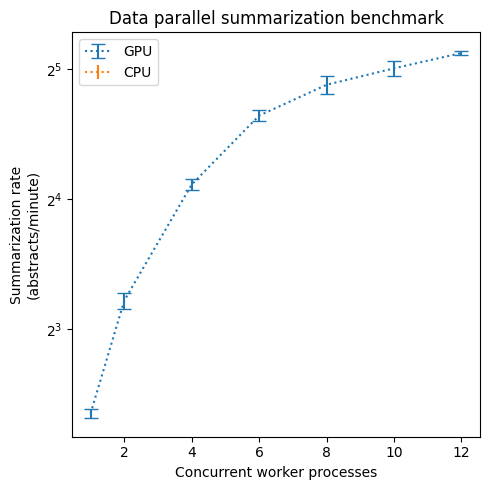

,abstracts,abstracts per worker,replicate,batches,device,workers,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,3,3,1,3,GPU,1,35.773529,0.083861,5.031653
1,3,3,2,3,GPU,1,34.718362,0.086410,5.184576
2,3,3,3,3,GPU,1,35.118542,0.085425,5.125498
3,3,3,4,3,GPU,1,34.337809,0.087367,5.242035
4,3,3,5,3,GPU,1,36.646051,0.081864,4.911853


In [19]:
data, plt = plot_funcs.parallel_summarization_plot('../benchmarks/parallel_summarization/results.csv')

plt.show()
data.head()

### 4. Model quantization

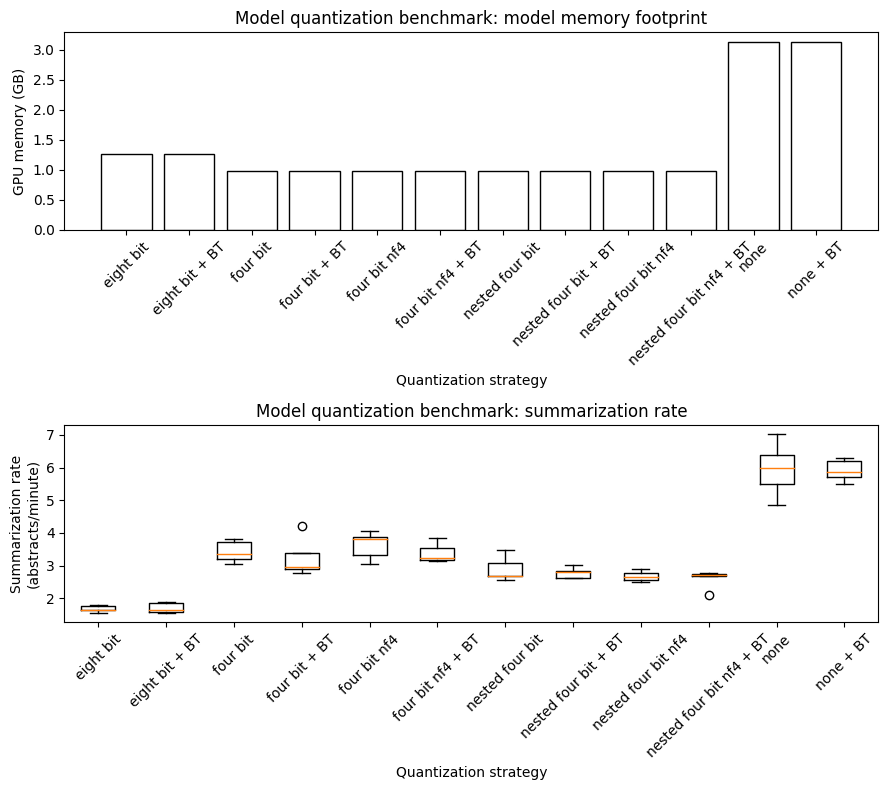

,replicate,abstracts,quantization strategy,summarization time (sec.),summarization rate (abstracts/sec.),model GPU memory footprint (bytes),max memory allocated (bytes),summarization rate (abstracts/min.),model GPU memory footprint (GB)
0,1,5,none,61.830029,0.080867,3132600320,3529794560,4.852011,3.1326
1,2,5,none,42.642623,0.117254,3132600320,3504366080,7.035214,3.1326
2,3,5,none,46.971549,0.106447,3132600320,3521668096,6.386845,3.1326
3,4,5,none,54.685516,0.091432,3132600320,3529925632,5.485913,3.1326
4,5,5,none,50.119571,0.099761,3132600320,3507119104,5.985686,3.1326


In [13]:
data, plt = plot_funcs.model_quantization_plot('../benchmarks/model_quantization/results.csv')

plt.show()
data.head()

### 5. Batched summarization

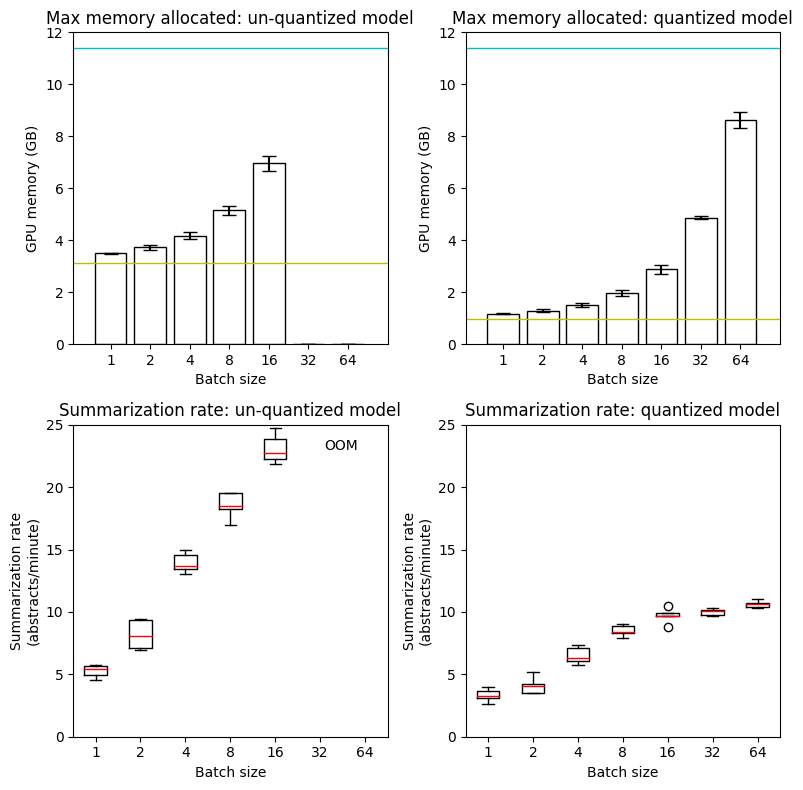

,abstracts,replicate,batches,batch size,quantization,summarization time (sec.),summarization rate (abstracts/sec.),model GPU memory footprint (bytes),max memory allocated (bytes),summarization rate (abstracts/min.),max memory allocated (GB)
0,3,1,3,1,none,31.231767,0.096056,3132600320,3486147072,5.763363,3.486147
1,3,2,3,1,none,36.369606,0.082486,3132600320,3495322112,4.949187,3.495322
2,3,3,3,1,none,32.947045,0.091055,3132600320,3507513344,5.463312,3.507513
3,3,4,3,1,none,31.640228,0.094816,3132600320,3491390976,5.688960,3.491391
4,3,5,3,1,none,39.483424,0.075981,3132600320,3499255296,4.558875,3.499255


In [14]:
data, plt = plot_funcs.batch_summarization_plot('../benchmarks/batched_summarization/results.csv')

plt.show()
data.head()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


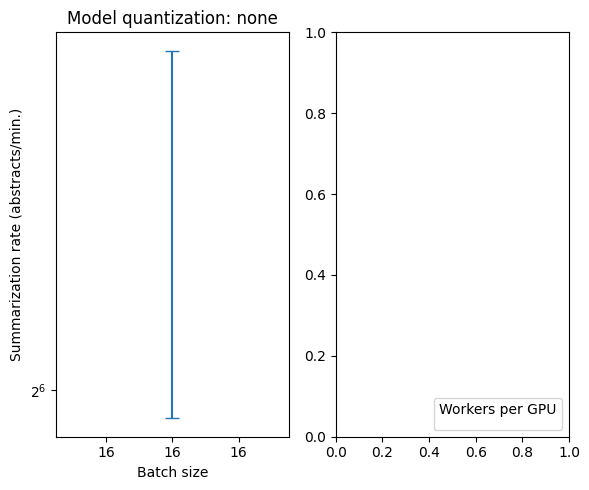

,abstracts,batches,replicate,batch size,workers,workers per GPU,quantization,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.),jobs per GPU
0,48,3,1,16,4,1,none,174.548988,1.099978,65.998664,1
1,48,3,2,16,4,1,none,138.162366,1.389669,83.380159,1


In [15]:
data, plt = plot_funcs.parallel_batched_summarization_plot('../benchmarks/parallel_batched_summarization/results.csv')

plt.show()
data.head(20)

### 6. SQL Insert

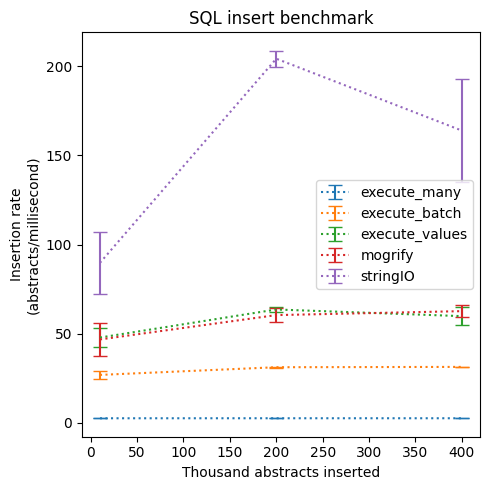

,abstracts,insert time (sec.),insert rate (abstracts/sec.),insert strategy,replicate,insert rate (abstracts/millisecond),thousand abstracts
0,10000,3.724415,2684.985381,execute_many,1,2.684985,10.0
1,10000,3.774634,2649.263727,execute_many,2,2.649264,10.0
2,10000,3.775181,2648.879578,execute_many,3,2.648880,10.0
3,200000,75.498859,2649.046659,execute_many,1,2.649047,200.0
4,200000,75.734771,2640.794947,execute_many,2,2.640795,200.0


In [16]:
data, plt = plot_funcs.sql_insert_plot('../benchmarks/sql_insert/results.csv')

plt.show()
data.head()